# Import necessary packages

In [109]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Load data
#### First, we will download our labels, which are in a csv file.

In [78]:
train_data_path = '/kaggle/input/airbus-ship-detection/train_v2'
train_csv = pd.read_csv('/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv')

# Exploratory Data Analysis
First, we'll see what our data looks like, and we'll also find out the number of pictures our data set has. 
As we can see, our dataframe contains 2 columns. The first is the ImageId of the picture, the second is the corresponding labels encoded by Run-length encoding -- EncodedPixels.

RLE is a simple method of compressing data by specifying the number of times a character or pixel colour repeats followed by the value of the character or pixel. The aim is to reduce the number of bits used to represent a set of data.


In [79]:
print(f'Number of train samples: {train_csv.shape[0]}')
train_csv.head()

Number of train samples: 231723


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [ ]:
images_with_ships = train_csv[train_csv['EncodedPixels'].notna()].ImageId.nunique()
images_without_ships = train_csv[train_csv['EncodedPixels'].isna()].ImageId.nunique()

print(f'Number of images with ships: {images_with_ships} | {round(images_with_ships / train_csv.ImageId.nunique() * 100)}%')
print(f'Number of images without ships: {images_without_ships} | {round(images_without_ships / train_csv.ImageId.nunique() * 100)}%')

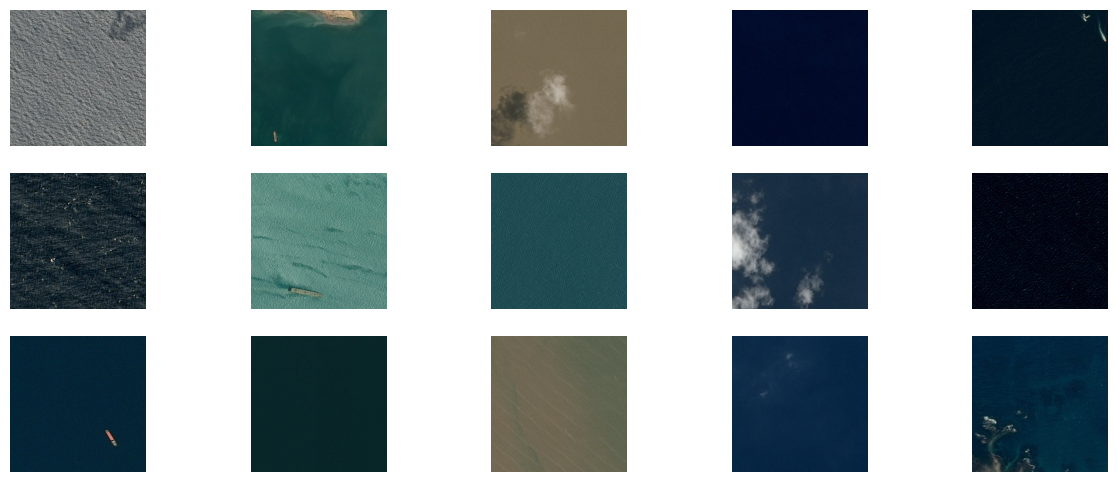

In [111]:
def display_images(folder_path, num_images=15, num_columns=5):
    # Get a list of all files in the folder
    image_files = [f for f in os.listdir(folder_path)[:num_images]]

    # Calculate the number of rows needed
    num_rows = (num_images + num_columns - 1) // num_columns

    # Display the images in a grid
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 6))

    for i in range(num_images):
        img_path = os.path.join(folder_path, image_files[i])
        img = imread(img_path)
        row_index, col_index = divmod(i, num_columns)
        axes[row_index, col_index].imshow(img)
        axes[row_index, col_index].axis('off')

    plt.show()

display_images(train_data_path, num_images=15, num_columns=5)

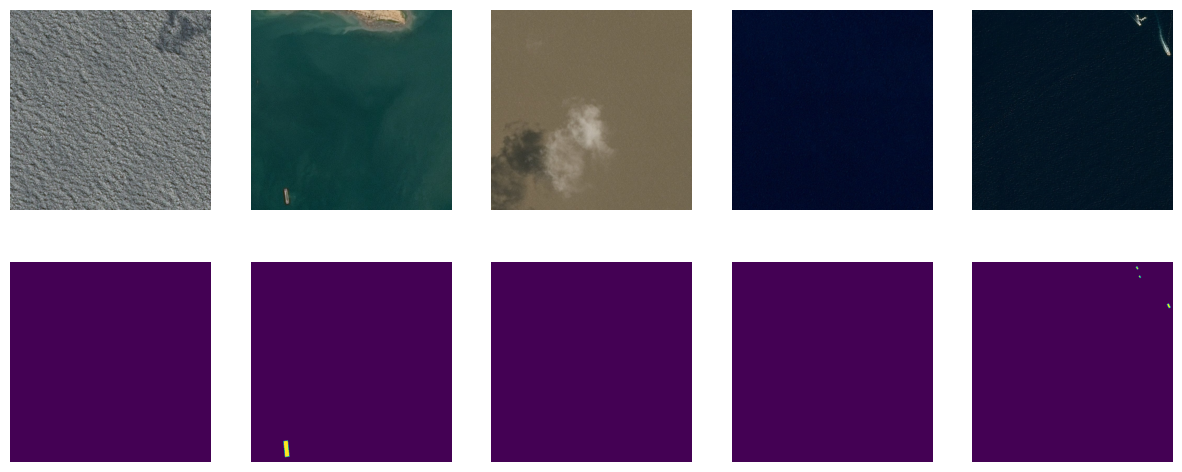

In [108]:
# Define your display_masks function
def display_masks(folder_path, csv_file, save_path, num_images=5):
    # Get a list of all files in the folder
    image_files = [f for f in os.listdir(folder_path)[:num_images]]

    # Calculate the number of rows needed
    num_rows = 2

    # Display the images in a grid
    fig, axes = plt.subplots(num_rows, num_images, figsize=(15, 6))

    for i in range(num_images):
        img_path = os.path.join(folder_path, image_files[i])
        img = imread(img_path)

        all_masks = csv_file[csv_file['ImageId'] == image_files[i]].EncodedPixels
        mask = np.zeros((768, 768))
        for m in all_masks:
            mask += rle_decode(m)

        axes[0, i].imshow(img)
        axes[0, i].axis('off')

        axes[1, i].imshow(mask)
        axes[1, i].axis('off')

    # Display the figure
    plt.show()

# Example usage:
display_masks(train_data_path, csv_file=train_csv, save_path='/kaggle/working/', num_images=5)

# Histogram of data destribution
Let's look at the distribution of our data, as can be seen from the histogram, the distribution of the two classes is uneven, so our dataset is imbalanced.

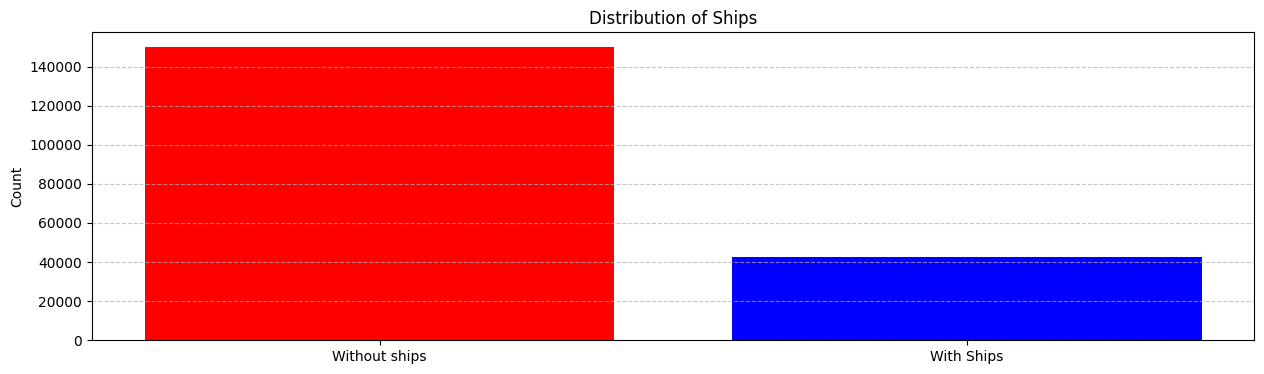

In [84]:
# Create subplots
fig, axes = plt.subplots(figsize=(15, 4))

# Plot bar chart
axes.bar(['Without ships', 'With Ships'], [images_without_ships, images_with_ships], color=['red', 'blue'])
axes.set_title('Distribution of Ships')
axes.set_ylabel('Count')
axes.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


 # Descriptive statistics of the distribution of the number of ships
 

In [85]:
ships_df = train_csv.dropna().groupby('ImageId').count()
ships_df.rename({'EncodedPixels': 'n_ships'}, axis='columns', inplace=True)

ships_df.describe()

,n_ships
count,42556.000000
mean,1.920364
std,1.906073
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,15.000000


In [ ]:
ships_df.n_ships.value_counts()

# Histogram of number of ships

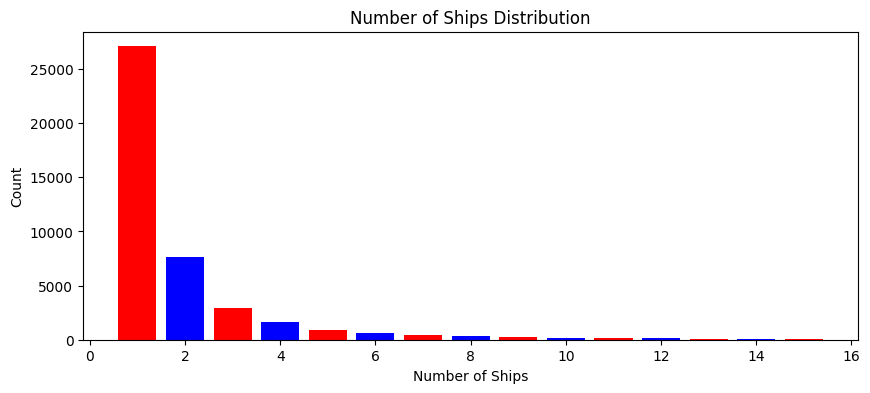

In [86]:
plt.figure(figsize=(10, 4))
plt.title('Number of Ships Distribution')
plt.xlabel('Number of Ships')
plt.ylabel('Count')
plt.bar(range(1, 16), ships_df.n_ships.value_counts(), color=['red', 'blue'])
plt.show()